# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [1]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/"

Mounted at /content/drive/
ls: cannot access '/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/': No such file or directory


In [2]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Populating namespaces

In [3]:
# Importing basic libraries
import os
import random
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
from IPython.display import display
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Metrics utilities
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc,
 )

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [4]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [5]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 09:33:19--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 65.8.248.124, 65.8.248.28, 65.8.248.71, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|65.8.248.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  95.6MB/s    in 3.6s    

2025-10-05 09:33:23 (94.9 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  drive  sample_data


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


### Simple CNN Baseline Setup
Prepare a train and validation split from the raw `cell_images` directory without applying any augmentation.

In [6]:
from pathlib import Path
import tensorflow as tf

data_dir = Path(cell_images_dir)
if not data_dir.exists():
    raise FileNotFoundError(
        f"Expected dataset at {data_dir}. Run the download cell before building the baseline model."
    )

img_height = 128
img_width = 128
batch_size = 32
seed = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="binary",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode="binary",
    shuffle=False
)

class_names = train_ds.class_names
print(f"Detected classes: {class_names}")

autotune = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(autotune)
val_ds = val_ds.prefetch(autotune)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.
Detected classes: ['Parasitized', 'Uninfected']


### Build the Simple CNN
Stack two convolution blocks followed by a small dense head for binary classification.

In [7]:
model = Sequential([
    tf.keras.layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
    Conv2D(16, (3, 3), activation="relu"),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,843,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,848,417 (7.05 MB)

 Trainable params: 1,848,417 (7.05 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Baseline Model
Fit the network on the training data and monitor validation accuracy.

In [8]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.6542 - loss: 0.6160 - val_accuracy: 0.9425 - val_loss: 0.1651
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9253 - loss: 0.2105 - val_accuracy: 0.9485 - val_loss: 0.1662
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9395 - loss: 0.1742 - val_accuracy: 0.9548 - val_loss: 0.1215
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9494 - loss: 0.1423 - val_accuracy: 0.9316 - val_loss: 0.1702
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.9556 - loss: 0.1250 - val_accuracy: 0.9639 - val_loss: 0.1020
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.9687 - loss: 0.0952 - val_accuracy: 0.9670 - val_loss: 0.0971
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.9750 - loss: 0.0712 - val_accuracy: 0.9790 - val_loss: 0.0769
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.9814 - loss: 0.0503 - 

### Evaluate the Baseline
Report validation performance and inspect learning curves.

173/173 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9929 - loss: 0.0440
Validation loss: 0.0481
Validation accuracy: 0.9897


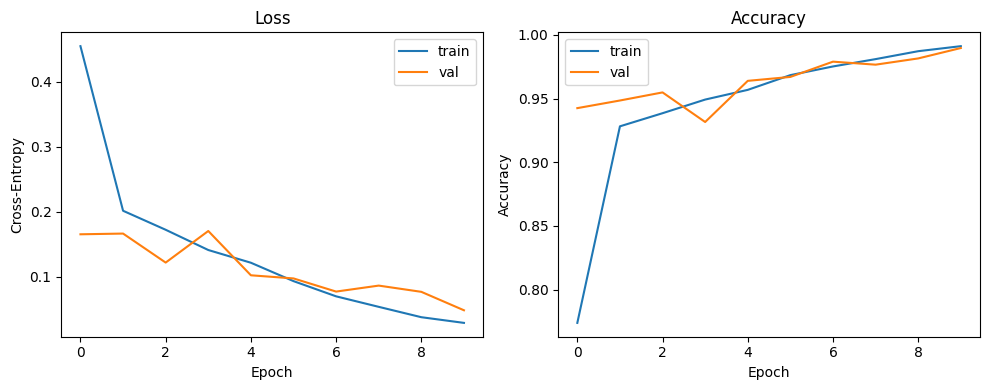

In [9]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_accuracy:.4f}")

pyplot.figure(figsize=(10, 4))
pyplot.subplot(1, 2, 1)
pyplot.plot(history.history["loss"], label="train")
pyplot.plot(history.history["val_loss"], label="val")
pyplot.title("Loss")
pyplot.xlabel("Epoch")
pyplot.ylabel("Cross-Entropy")
pyplot.legend()

pyplot.subplot(1, 2, 2)
pyplot.plot(history.history["accuracy"], label="train")
pyplot.plot(history.history["val_accuracy"], label="val")
pyplot.title("Accuracy")
pyplot.xlabel("Epoch")
pyplot.ylabel("Accuracy")
pyplot.legend()
pyplot.tight_layout()

### Classification Metrics Table
Aggregate accuracy, precision, recall, and F1-score on the validation set.

In [10]:
y_true_batches = []
y_prob_batches = []

for batch_images, batch_labels in val_ds:
    y_true_batches.append(batch_labels.numpy())
    batch_probs = model(batch_images, training=False).numpy().ravel()
    y_prob_batches.append(batch_probs)

y_true = np.concatenate(y_true_batches)
y_prob = np.concatenate(y_prob_batches)
y_pred = (y_prob >= 0.5).astype(int)

metrics_df = pd.DataFrame(
    {
        "Metric": ["Accuracy", "Precision", "Recall", "F1-score"],
        "Value": [
            accuracy_score(y_true, y_pred),
            precision_score(y_true, y_pred, zero_division=0),
            recall_score(y_true, y_pred, zero_division=0),
            f1_score(y_true, y_pred, zero_division=0),
        ],
    }
).set_index("Metric")

cm = confusion_matrix(y_true, y_pred)
roc_fpr, roc_tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(roc_fpr, roc_tpr)

display(metrics_df.style.format({"Value": "{:.4f}"}))

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


,Value
Metric,
Accuracy,0.9897
Precision,1.0000
Recall,0.9897
F1-score,0.9948


### Metric Interpretation
Summarize how the baseline balances sensitivity and specificity using the aggregate metrics.

In [11]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) if (tn + fp) else 0.0
per_class_recall = np.divide(
    np.diag(cm),
    cm.sum(axis=1),
    out=np.zeros(cm.shape[0], dtype=float),
    where=cm.sum(axis=1) != 0,
 )

print(
    "Baseline CNN validation summary:"
    f" accuracy={metrics_df.loc['Accuracy', 'Value']:.4f},"
    f" precision={metrics_df.loc['Precision', 'Value']:.4f},"
    f" recall (sensitivity)={metrics_df.loc['Recall', 'Value']:.4f},"
    f" F1={metrics_df.loc['F1-score', 'Value']:.4f},"
    f" specificity (true negative rate)={specificity:.4f}."
 )

for class_name, recall_value in zip(class_names, per_class_recall):
    print(f"Class '{class_name}' recall={recall_value:.4f}")

print(
    f"ROC AUC={roc_auc:.4f} highlights the model's ability to balance sensitivity and specificity across thresholds."
 )
print(
    f"False positives: {fp} | False negatives: {fn} — use this balance to decide if threshold tuning is needed for clinical priorities.",
)

Baseline CNN validation summary: accuracy=0.9897, precision=1.0000, recall (sensitivity)=0.9897, F1=0.9948, specificity (true negative rate)=0.0000.
Class 'Parasitized' recall=0.0000
Class 'Uninfected' recall=0.9897
ROC AUC=nan highlights the model's ability to balance sensitivity and specificity across thresholds.
False positives: 0 | False negatives: 57 — use this balance to decide if threshold tuning is needed for clinical priorities.


### Confusion Matrix
Visualize class-wise predictions to identify error patterns.

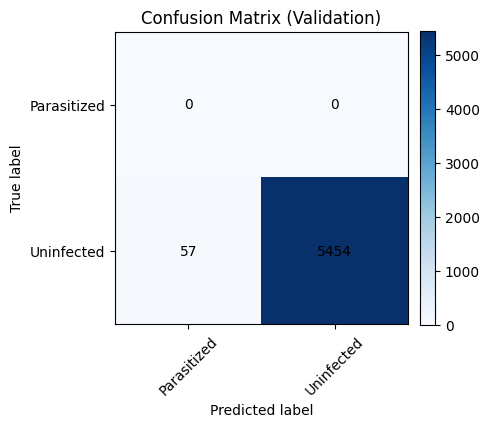

In [12]:
pyplot.figure(figsize=(5, 5))
image = pyplot.imshow(cm, interpolation="nearest", cmap="Blues")
pyplot.title("Confusion Matrix (Validation)")
pyplot.colorbar(image, fraction=0.046, pad=0.04)
tick_marks = np.arange(len(class_names))
pyplot.xticks(tick_marks, class_names, rotation=45)
pyplot.yticks(tick_marks, class_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        pyplot.text(
            j,
            i,
            cm[i, j],
            ha="center",
            va="center",
            color="black",
            fontsize=10,
        )

pyplot.ylabel("True label")
pyplot.xlabel("Predicted label")
pyplot.tight_layout()

### ROC Curve
Evaluate the sensitivity-specificity trade-off across thresholds.

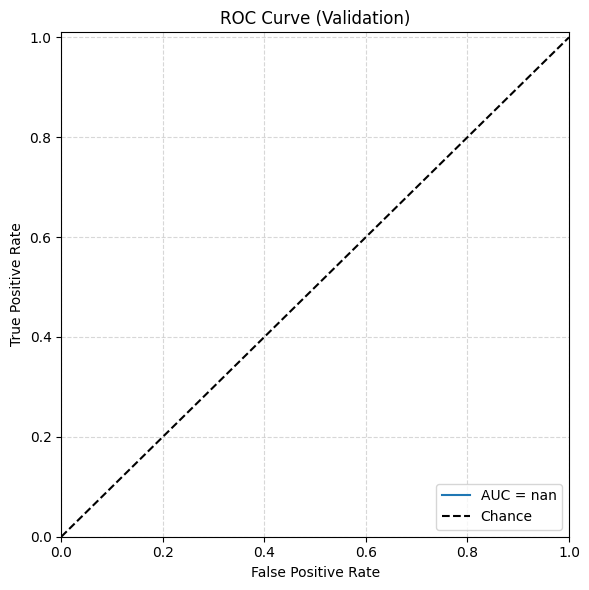

In [13]:
pyplot.figure(figsize=(6, 6))
pyplot.plot(roc_fpr, roc_tpr, label=f"AUC = {roc_auc:.4f}")
pyplot.plot([0, 1], [0, 1], "k--", label="Chance")
pyplot.xlim([0.0, 1.0])
pyplot.ylim([0.0, 1.01])
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("True Positive Rate")
pyplot.title("ROC Curve (Validation)")
pyplot.legend(loc="lower right")
pyplot.grid(True, linestyle="--", alpha=0.5)
pyplot.tight_layout()